In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [205]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


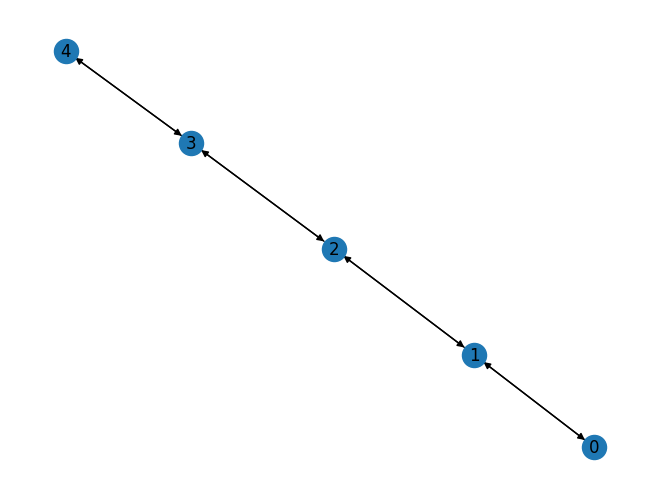

tensor([[0.5000, 0.0000, 0.3127],
        [1.5000, 0.0000, 0.4769],
        [2.5000, 0.0000, 0.3191],
        [3.5000, 0.0000, 0.0073],
        [4.5000, 0.0000, 0.3541]])


In [290]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    
    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Concat node features and load
    node_features = torch.cat([pos, load], dim=1)

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])   
    
    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)
    
    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 3, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.x)

In [291]:
# Import data
import pandas as pd

df = pd.read_json(r"C:\Users\kurt-\Documents\GitHub\dsa-2024\data\JSON_Data_Updated\n=100_p=1_varying_l_vectors.json")

In [292]:
np.array(df[1][0][0]) - np.array(df[1][0][1])

array([-0.1010101,  0.       ])

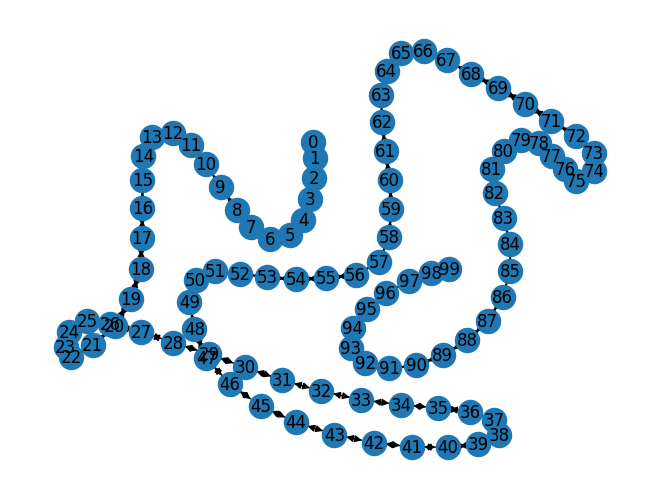

In [294]:
# Example usage with beam data

metadata["default_connectivity_radius"] = 0.1011
metadata["E_initial"] = 10
metadata["P_initial"] = 0.5

A  = create_gnn_graph(df[1][0], metadata)

graph = to_networkx(A)
nx.draw(graph, with_labels=True)
plt.show()

In [296]:
# Encoder
import torch
import torch.nn as nn
class Encoder(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim,):
        super().__init__()
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out), nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out), nn.LayerNorm(node_out)])

    def reset_parameters(self):
        self.mlp.reset_parameters()

    def forward(self, node_pos, edge_index, edge_attr):
        return self.node_fn(node_pos), self.edge_fn(edge_attr)


In [298]:
node_in = metadata["node_input_size"]
node_out = 100
edge_in = metadata["edge_input_size"]
edge_out = 100

mlp_num_layers = 4
mlp_hidden_dim = 10

encoder = Encoder(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
encoder.forward(A.x, A.edge_index, A.edge_attr)

(tensor([[-1.5820,  1.0572,  1.4397,  ..., -1.2259, -1.3806,  0.6131],
         [-1.5817,  1.0575,  1.4395,  ..., -1.2258, -1.3807,  0.6129],
         [-1.5750,  1.0644,  1.4355,  ..., -1.2244, -1.3836,  0.6074],
         ...,
         [-1.5711,  1.0401,  1.4666,  ..., -1.2238, -1.3840,  0.6184],
         [-1.5711,  1.0395,  1.4673,  ..., -1.2239, -1.3839,  0.6186],
         [-1.5711,  1.0388,  1.4680,  ..., -1.2240, -1.3839,  0.6189]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[ 1.5910,  0.2165, -0.7778,  ..., -1.4313, -0.9541,  0.8325],
         [ 1.5961,  0.0792, -0.8694,  ..., -1.4477, -0.9267,  0.6706],
         [ 1.5819,  0.0917, -0.8539,  ..., -1.4439, -0.9346,  0.6732],
         ...,
         [ 1.6435,  0.2187, -0.7783,  ..., -1.4558, -0.9676,  0.8743],
         [ 1.5890,  0.0961, -0.8514,  ..., -1.4464, -0.9385,  0.6851],
         [ 1.6894,  0.2311, -0.7421,  ..., -1.5195, -0.9728,  0.9066]],
        grad_fn=<NativeLayerNormBackward0>))